In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "./GEO Samples/Ov_merged_data_with_metadata.csv"
ov_samples = pd.read_csv(filepath)

In [3]:
# Drop ID and lable column
X = ov_samples.drop(['ID', 'Stage'], axis=1, inplace=False)
y = ov_samples[['Stage']]
y['Stage'].value_counts()

Stage
3    331
1    265
2     72
4     32
Name: count, dtype: int64

In [4]:
from sklearn.ensemble import IsolationForest

# Initialize the model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model
iso_forest.fit(X)

# Predict outliers
outlier_labels_iso = iso_forest.predict(X)  # -1 for outliers, 1 for inliers

print(Counter(outlier_labels_iso))

outlier_indices_iso = np.where(outlier_labels_iso == -1)[0]
outlier_indices_iso

Counter({1: 669, -1: 31})


array([  3,   8,  43,  45,  56,  77,  86, 100, 101, 138, 174, 175, 183,
       223, 266, 355, 369, 388, 398, 414, 432, 448, 453, 487, 505, 508,
       543, 573, 598, 627, 681], dtype=int64)

In [5]:
from sklearn.decomposition import PCA


# Fit PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate reconstruction error
reconstruction_error = np.mean((X - X_reconstructed) ** 2, axis=1)

# Determine outliers based on a threshold
threshold = np.percentile(reconstruction_error, 95)
outlier_labels_pca = reconstruction_error > threshold

print(Counter(outlier_labels_pca))

outlier_indices_pca = np.where(outlier_labels_pca == True)[0]
outlier_indices_pca

Counter({False: 666, True: 34})


array([ 42,  43,  94,  95, 101, 138, 174, 175, 223, 266, 270, 275, 285,
       292, 301, 338, 356, 360, 362, 365, 414, 429, 476, 513, 514, 543,
       598, 627, 633, 650, 682, 684, 686, 689], dtype=int64)

In [6]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the model
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# Fit the model and predict outliers
outlier_labels_lof = lof.fit_predict(X)  # -1 for outliers, 1 for inliers
print(Counter(outlier_labels_lof))

outlier_indices_lof = np.where(outlier_labels_lof == -1)[0]
outlier_indices_lof

Counter({1: 672, -1: 28})


array([ 43,  95, 118, 174, 175, 223, 249, 266, 292, 312, 325, 338, 350,
       355, 356, 370, 371, 374, 414, 442, 514, 530, 598, 627, 658, 681,
       682, 692], dtype=int64)

In [7]:
# Convert to sorted list (optional, for ordered output)

# # Compare overlap
overlap = set(outlier_indices_pca) & set(outlier_indices_lof)
print(f"Overlap count: {len(overlap)}")
print(f"Overlap indices: {sorted(overlap)}")


overlap_sorted = sorted(overlap)


Overlap count: 14
Overlap indices: [43, 95, 174, 175, 223, 266, 292, 338, 356, 414, 514, 598, 627, 682]


In [8]:
# # Compare overlap
overlap = set(outlier_indices_pca) & set(outlier_indices_lof) & set(outlier_indices_iso) 
print(f"Overlap count: {len(overlap)}")
print(f"Overlap indices: {sorted(overlap)}")


overlap_sorted = sorted(overlap)

Overlap count: 8
Overlap indices: [43, 174, 175, 223, 266, 414, 598, 627]


In [10]:
# Drop the outliers!
X = X.drop(overlap_sorted).reset_index(drop=True)
y = y.drop(overlap_sorted).reset_index(drop=True)

,Age,MIMAT0004501,MIMAT0002844,MIMAT0002843,MIMAT0002824,MIMAT0002823,MIMAT0002807,MIMAT0002806,MIMAT0001635,MIMAT0001631,...,MIMAT0022965,MIMAT0022948,MIMAT0027678,MIMAT0027677,MIMAT0027662,MIMAT0027661,MIMAT0027646,MIMAT0027645,MIMAT0027630,MIMAT0027629
0,56,52.467861,53.021144,50.275415,58.987391,53.941752,54.889724,54.923904,52.362241,61.854267,...,52.486087,59.057645,63.943554,51.248290,54.046993,60.030709,51.739650,58.136470,55.099968,54.653252
1,68,55.456073,55.596486,53.736900,55.706964,52.785368,55.302592,54.983990,55.450371,67.605034,...,50.846904,51.088529,56.364364,49.775866,52.393827,54.766599,53.193541,56.368165,55.261253,49.661587
2,32,54.429407,53.664278,51.663155,54.857878,53.620057,55.033662,52.534587,51.803262,52.485169,...,49.834865,53.584380,61.506332,50.782825,51.149963,56.163727,47.778377,52.041833,50.912516,49.146638
3,52,50.677996,51.229936,50.756919,52.846291,50.266261,54.602851,49.028448,50.333692,52.989106,...,51.025317,51.818724,54.903512,47.921436,49.661399,54.147474,50.916331,53.205626,49.421499,47.606787
4,40,49.869326,50.596737,53.429290,53.915722,50.766180,50.930070,53.944855,52.397999,55.266159,...,55.896899,57.862050,57.637417,56.444074,55.201099,58.201697,57.099792,59.285261,60.086523,56.961797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,38,56.605380,61.088193,57.824787,75.537419,58.561304,62.807969,61.290182,55.613813,90.513397,...,54.771599,77.011720,75.020213,58.903700,54.218937,74.107539,54.017055,67.721184,71.625404,65.930919
688,59,50.355173,54.255383,56.652122,72.984746,55.774347,63.042314,57.222127,54.381319,78.737545,...,49.656376,72.570242,85.099610,48.560569,52.807895,75.189871,53.872718,68.820404,64.708980,59.091917
689,54,52.493641,58.399338,52.554567,58.901810,53.048722,59.012097,56.101727,53.889849,60.024961,...,50.057292,67.494830,59.773463,47.796053,50.318010,63.211636,50.501562,57.538726,54.346729,57.824251
690,62,51.777089,54.593145,51.966246,68.846821,54.521761,65.397567,54.550882,55.810114,60.583142,...,49.687674,68.603991,68.516205,46.882808,54.042299,61.398654,50.486784,61.848352,63.151477,56.918871


In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=20)


In [ ]:
# y_train['Stage'].value_counts()

In [ ]:
# # Oversample rows where y == 4

# # Stage 4 originally has 32 samples. We repute each one 8 times = 288
# n = 8
# mask = y_train['Stage'] == 4

# X_Stage_4 = X_train[mask]
# y_Stage_4 = y_train[mask]
# y_Stage_4

# X_train_oversampled = pd.concat([X_train, pd.concat([X_Stage_4]*n)], ignore_index=True)
# y_train_oversampled = pd.concat([y_train, pd.concat([y_Stage_4]*n)], ignore_index=True)


# # Oversample rows where y == 2
# # Stage 2 originally has 72 samples. We repute each one 3 times = 288
# n = 3
# mask = y_train["Stage"] == 2

# X_Stage_2 = X_train[mask]
# y_Stage_2 = y_train[mask]

# X_train_oversampled = pd.concat([X_train_oversampled, pd.concat([X_Stage_2]*n)], ignore_index=True)
# y_train_oversampled = pd.concat([y_train_oversampled, pd.concat([y_Stage_2]*n)], ignore_index=True)

# y_train_oversampled['Stage'].value_counts()

In [12]:
from imblearn.over_sampling import BorderlineSMOTE

# Apply Borderline-SMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

y_train_oversampled['Stage'].value_counts()

Stage
3    260
1    260
2    260
4    260
Name: count, dtype: int64

In [13]:
# Shuffle the oversampled training data
shuffled = X_train_oversampled.join(y_train_oversampled).sample(frac=1, random_state=42).reset_index(drop=True)
X_train = shuffled.drop(columns='Stage')
y_train = shuffled['Stage']

In [ ]:
# print("Train min:", X_train.min().min())
# print("Train max:", X_train.max().max())
# print("Test min:", X_test.min().min())
# print("Test max:", X_test.max().max())

In [14]:
# Normalization with Min-Max
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
normalized_train_samples = pd.DataFrame(X_train_scaled, columns= X.columns)
normalized_test_samples = pd.DataFrame(X_test_scaled, columns= X.columns)

X_train = normalized_train_samples.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = normalized_test_samples.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [19]:
# Train Random Forest on full data and get feature importances
from sklearn.ensemble import RandomForestClassifier
import numpy as np

x = X_train
y = y_train
k = 200
# Train a model
model = RandomForestClassifier(n_estimators=k, random_state=42, class_weight='balanced')
model.fit(x, y)

# Get feature importances and select top k
RF_importances = model.feature_importances_
indices = np.argsort(RF_importances)[::-1]  # Sort descending


top_indices = indices[:k]


In [20]:
top_indices.shape

(200,)

In [21]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

mi_selector = SelectKBest(score_func=mutual_info_classif, k=k)
x_mi_selected = mi_selector.fit_transform(x, y)

# Get the actual indices of selected features
mi_indices = mi_selector.get_support(indices=True)
mi_indices

array([  19,   20,   76,   99,  105,  138,  155,  187,  188,  209,  218,
        227,  237,  260,  308,  316,  330,  342,  365,  372,  380,  386,
        417,  432,  437,  460,  472,  475,  499,  501,  512,  528,  529,
        531,  544,  546,  570,  582,  621,  630,  660,  670,  702,  708,
        712,  713,  717,  732,  757,  766,  767,  770,  772,  773,  788,
        790,  797,  827,  828,  834,  859,  876,  900,  921,  923,  938,
        949,  973,  995, 1012, 1013, 1014, 1022, 1025, 1027, 1036, 1080,
       1083, 1092, 1102, 1108, 1117, 1140, 1150, 1160, 1163, 1165, 1169,
       1179, 1181, 1185, 1190, 1193, 1194, 1195, 1208, 1232, 1251, 1259,
       1263, 1267, 1298, 1313, 1315, 1316, 1317, 1348, 1349, 1404, 1422,
       1450, 1454, 1460, 1474, 1475, 1496, 1498, 1502, 1503, 1523, 1550,
       1560, 1564, 1575, 1576, 1589, 1613, 1614, 1619, 1639, 1657, 1661,
       1693, 1699, 1751, 1793, 1803, 1804, 1815, 1847, 1863, 1889, 1910,
       1945, 1951, 1970, 1972, 1976, 1977, 1978, 19

In [ ]:
# # Get top k feature indices by model importance
# top_k_model_indices = np.argsort(RF_importances)[::-1][:k]

# # Compare overlap
# overlap = set(mi_indices) & set(top_k_model_indices)
# print(f"Overlap count: {len(overlap)} out of {k}")
# print(f"Overlap indices: {sorted(overlap)}")


In [ ]:
# # Convert to sorted list (optional, for ordered output)
# overlap_sorted = sorted(overlap)

# # Get corresponding feature names
# overlap_feature_names = x.columns[overlap_sorted]

# # Display or use them
# print(overlap_feature_names)

In [22]:
from collections import OrderedDict
combined = list(set(top_indices).union(set(mi_indices)))
len(combined)

306

In [23]:
x_train = x.iloc[:, sorted(combined)]
x_train

,Age,MIMAT0001631,MIMAT0016907,MIMAT0016901,MIMAT0025846,MIMAT0027511,MIMAT0032116,MIMAT0030999,MIMAT0003214,MIMAT0007888,...,MIMAT0028211,MIMAT0028111,MIMAT0018943,MIMAT0019788,MIMAT0022709,MIMAT0019838,MIMAT0027373,MIMAT0027678,MIMAT0027662,MIMAT0027661
0,0.803030,0.012281,0.140242,0.136311,0.083345,0.147720,0.144005,0.150574,0.331422,0.299815,...,0.110530,0.121234,0.330394,0.088957,0.053339,0.045183,0.167055,0.193797,0.311824,0.270007
1,0.621212,0.020183,0.167109,0.139962,0.087217,0.240417,0.240979,0.119501,0.565580,0.301098,...,0.067503,0.097025,0.372763,0.103721,0.073428,0.052727,0.226936,0.173123,0.327254,0.311055
2,0.954545,0.038957,0.327478,0.152080,0.107795,0.382203,0.297059,0.255174,0.503430,0.390896,...,0.103289,0.175846,0.464245,0.181457,0.091792,0.063592,0.281811,0.291003,0.344197,0.358671
3,0.454545,0.092669,0.069538,0.115482,0.207068,0.098354,0.144687,0.119011,0.267894,0.255840,...,0.055619,0.105886,0.451175,0.175545,0.047188,0.063402,0.374700,0.150071,0.161552,0.290065
4,0.696970,0.059941,0.309787,0.183550,0.099055,0.306803,0.321365,0.327519,0.432830,0.322177,...,0.157746,0.128128,0.390707,0.124505,0.054955,0.046760,0.248833,0.209500,0.313045,0.324529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.590909,0.019974,0.124391,0.084124,0.045652,0.102572,0.140616,0.073812,0.235193,0.201723,...,0.052257,0.079543,0.169364,0.055358,0.045826,0.023863,0.116918,0.062467,0.200010,0.142934
1036,0.606061,0.011886,0.162350,0.136793,0.080769,0.234166,0.159589,0.210603,0.429655,0.331125,...,0.076651,0.137543,0.288872,0.147791,0.067018,0.055330,0.225330,0.222059,0.327026,0.265503
1037,0.227273,0.017818,0.172869,0.139595,0.063506,0.264634,0.285056,0.193876,0.385897,0.247711,...,0.087258,0.095243,0.286958,0.124496,0.060200,0.034911,0.254837,0.187631,0.335962,0.319294
1038,0.575758,0.017671,0.155567,0.070347,0.065204,0.170258,0.176065,0.138356,0.308139,0.167086,...,0.038767,0.054959,0.137884,0.020692,0.033737,0.014347,0.116221,0.065914,0.096739,0.090771


In [24]:
x_test = X_test.iloc[:, sorted(combined)]
x_test

,Age,MIMAT0001631,MIMAT0016907,MIMAT0016901,MIMAT0025846,MIMAT0027511,MIMAT0032116,MIMAT0030999,MIMAT0003214,MIMAT0007888,...,MIMAT0028211,MIMAT0028111,MIMAT0018943,MIMAT0019788,MIMAT0022709,MIMAT0019838,MIMAT0027373,MIMAT0027678,MIMAT0027662,MIMAT0027661
0,0.484848,0.157723,0.194999,0.138077,0.145497,0.355497,0.253892,0.279241,0.555184,0.308865,...,0.146055,0.168726,0.569884,0.170871,0.092172,0.066844,0.267771,0.287197,0.319768,0.467461
1,0.909091,0.047250,0.149727,0.190149,0.228469,0.219764,0.264964,0.241286,0.275633,0.341830,...,0.171529,0.296186,0.796315,0.323821,0.149332,0.097330,0.634590,0.341650,0.488345,0.661809
2,0.590909,0.024739,0.140818,0.049686,0.049196,0.097323,0.099999,0.114411,0.324311,0.196682,...,0.029517,0.048610,0.135141,0.022688,0.016118,0.012045,0.168555,0.043957,0.090300,0.109857
3,0.818182,0.015181,0.614951,0.814173,0.123104,0.715851,0.515628,0.665745,0.595128,0.656006,...,0.493869,1.003623,0.569656,0.441083,0.229527,0.148420,0.469923,0.574681,0.606448,0.868851
4,0.575758,0.012441,0.506990,0.315036,0.046777,0.468274,0.301740,0.463220,0.463635,0.621077,...,0.273786,0.213638,0.339437,0.189687,0.077917,0.074352,0.241023,0.303367,0.384187,0.570782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0.303030,0.025065,0.474450,0.225821,0.084965,0.315619,0.300282,0.371311,0.426316,0.396588,...,0.249677,0.183126,0.374453,0.130667,0.065805,0.045537,0.222740,0.224056,0.314267,0.387385
135,0.545455,0.000498,0.084005,0.010862,0.000000,0.075326,0.006944,0.083445,0.111425,0.058853,...,0.017268,0.034516,0.021174,0.013583,0.000000,0.004113,0.006577,0.026133,0.008554,0.034325
136,0.424242,0.028833,0.246575,0.242011,0.171553,0.332773,0.137244,0.326952,0.317379,0.579913,...,0.296715,0.267629,0.610165,0.357656,0.214873,0.220006,0.824679,0.464211,0.773696,0.685914
137,0.621212,0.034664,0.236628,0.132755,0.079687,0.193769,0.222790,0.146474,0.414706,0.209752,...,0.039868,0.085098,0.271043,0.074465,0.054976,0.029219,0.267723,0.178946,0.269594,0.341686


In [25]:
data = pd.concat([y_train, x_train], axis=1)
df_filtered = data[data['Stage'].isin([3, 4])]
xx = df_filtered.drop(["Stage"], axis = 1)
yy = df_filtered[['Stage']]
xx

,Age,MIMAT0001631,MIMAT0016907,MIMAT0016901,MIMAT0025846,MIMAT0027511,MIMAT0032116,MIMAT0030999,MIMAT0003214,MIMAT0007888,...,MIMAT0028211,MIMAT0028111,MIMAT0018943,MIMAT0019788,MIMAT0022709,MIMAT0019838,MIMAT0027373,MIMAT0027678,MIMAT0027662,MIMAT0027661
0,0.803030,0.012281,0.140242,0.136311,0.083345,0.147720,0.144005,0.150574,0.331422,0.299815,...,0.110530,0.121234,0.330394,0.088957,0.053339,0.045183,0.167055,0.193797,0.311824,0.270007
2,0.954545,0.038957,0.327478,0.152080,0.107795,0.382203,0.297059,0.255174,0.503430,0.390896,...,0.103289,0.175846,0.464245,0.181457,0.091792,0.063592,0.281811,0.291003,0.344197,0.358671
3,0.454545,0.092669,0.069538,0.115482,0.207068,0.098354,0.144687,0.119011,0.267894,0.255840,...,0.055619,0.105886,0.451175,0.175545,0.047188,0.063402,0.374700,0.150071,0.161552,0.290065
5,0.651515,0.022317,0.716540,0.682090,0.069052,0.570450,0.517826,0.739095,0.630797,0.962134,...,0.487871,0.580847,0.384996,0.245498,0.182454,0.126768,0.274249,0.490873,0.444844,0.741249
7,0.666667,0.023307,0.429469,0.297312,0.082731,0.678513,0.370944,0.551173,0.413521,0.526311,...,0.266537,0.448251,0.524508,0.281150,0.153297,0.091513,0.276862,0.459926,0.402168,0.624931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.878788,0.022448,0.303722,0.196760,0.068830,0.295993,0.233732,0.205265,0.472636,0.370578,...,0.097425,0.172787,0.420155,0.118809,0.101380,0.063160,0.258317,0.212537,0.336828,0.375776
1034,0.681818,0.032554,0.746049,0.670343,0.145669,0.656690,0.461509,0.820516,0.579204,0.902020,...,0.513487,0.646734,0.444225,0.494353,0.193108,0.168795,0.385392,0.668341,0.406502,0.839278
1035,0.590909,0.019974,0.124391,0.084124,0.045652,0.102572,0.140616,0.073812,0.235193,0.201723,...,0.052257,0.079543,0.169364,0.055358,0.045826,0.023863,0.116918,0.062467,0.200010,0.142934
1038,0.575758,0.017671,0.155567,0.070347,0.065204,0.170258,0.176065,0.138356,0.308139,0.167086,...,0.038767,0.054959,0.137884,0.020692,0.033737,0.014347,0.116221,0.065914,0.096739,0.090771


In [ ]:
yy.shape


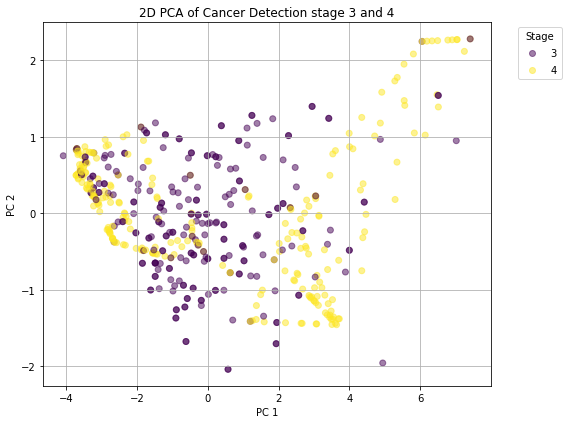

In [26]:
from sklearn.decomposition import PCA


# Reduce to 2 principal components
pca = PCA(n_components=2)
x_pca = pca.fit_transform(xx)

df_pca = pd.DataFrame(x_pca, columns=["PC1", "PC2"])
df_pca["Stage"] = yy.values


# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca["PC1"], df_pca["PC2"],
    c=yy["Stage"],
    cmap='viridis',        # Try 'Set1', 'tab20', or 'nipy_spectral' for more color variety
    alpha=0.5           # Higher opacity
)
plt.legend(*scatter.legend_elements(), title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("2D PCA of Cancer Detection stage 3 and 4")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()

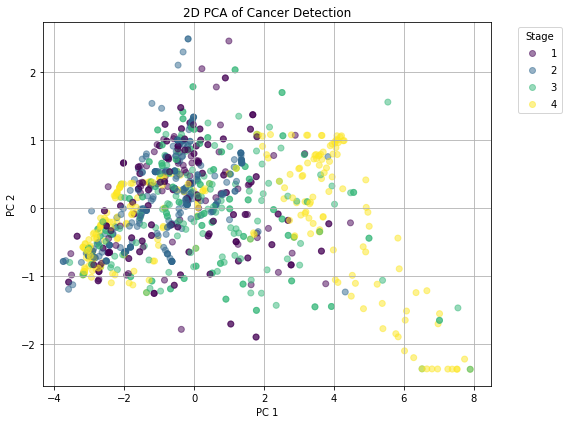

In [28]:
from sklearn.decomposition import PCA


# Reduce to 2 principal components
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train)

df_pca = pd.DataFrame(x_pca, columns=["PC1", "PC2"])
df_pca["Stage"] = y.values


# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca["PC1"], df_pca["PC2"],
    c=y,
    cmap='viridis',        # Try 'Set1', 'tab20', or 'nipy_spectral' for more color variety
    alpha=0.5           # Higher opacity
)
plt.legend(*scatter.legend_elements(), title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("2D PCA of Cancer Detection")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()

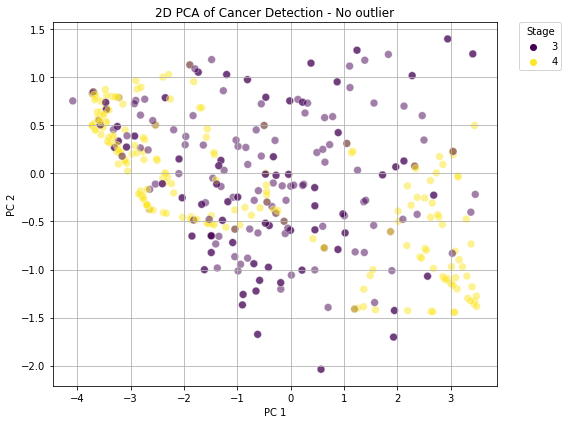

In [27]:
# Drop the Outliers!

df = df_pca
s1 = df_pca[df_pca["PC1"] > 3.5]
df = df.drop(s1.index.tolist())

# Step 4: Seaborn scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="PC1", y="PC2",
    hue="Stage",
    palette="viridis",
    alpha=0.5,
    s=60
)
plt.title("2D PCA of Cancer Detection - No outlier")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.legend(title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

In [29]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv=5)
calibrated_model.fit(x_train, y_train)


# Predict on test set
y_pred = calibrated_model.predict(x_test)

# Evaluate
print("calibrated Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


calibrated Classifier
--------------------------
Accuracy: 0.841726618705036
Confusion Matrix:
 [[45  2  6  0]
 [ 1 13  0  1]
 [ 1  0 59  5]
 [ 0  0  6  0]]
Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.85      0.90        53
           2       0.87      0.87      0.87        15
           3       0.83      0.91      0.87        65
           4       0.00      0.00      0.00         6

    accuracy                           0.84       139
   macro avg       0.66      0.66      0.66       139
weighted avg       0.85      0.84      0.84       139



Logistic Regression
--------------------------
Accuracy: 0.5971223021582733
Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.58      0.63        53
           2       0.41      0.47      0.44        15
           3       0.69      0.69      0.69        65
           4       0.00      0.00      0.00         6

    accuracy                           0.60       139
   macro avg       0.45      0.44      0.44       139
weighted avg       0.63      0.60      0.61       139



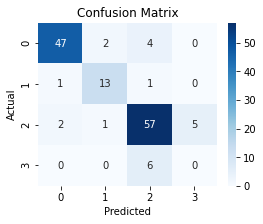

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



# Create and train the model
lg_model = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear', max_iter=1000)
lg_model.fit(x_train, y_train)

# Predict on test set
y_pred = lg_model.predict(x_test)

# Evaluate
print("Logistic Regression\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


XGBoost Classifier
--------------------------
Accuracy: 0.841726618705036
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.89      0.91        53
           2       0.81      0.87      0.84        15
           3       0.84      0.88      0.86        65
           4       0.00      0.00      0.00         6

    accuracy                           0.84       139
   macro avg       0.65      0.66      0.65       139
weighted avg       0.84      0.84      0.84       139



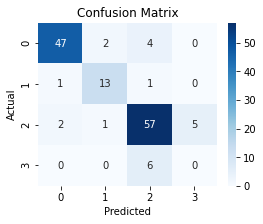

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode labels to 0-based indices
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_), 
    eval_metric="mlogloss",
    random_state=42
)
xgb_model.fit(x_train, y_encoded)

# Predict on test set
y_pred_encoded = xgb_model.predict(x_test)
y_pred = le.inverse_transform(y_pred_encoded) 

# Evaluate performance
cm = confusion_matrix(y_test, y_pred)

print("XGBoost Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Random Forest Classifier
--------------------------
Accuracy: 0.8201438848920863
Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.85      0.87        53
           2       0.87      0.87      0.87        15
           3       0.81      0.86      0.84        65
           4       0.00      0.00      0.00         6

    accuracy                           0.82       139
   macro avg       0.64      0.64      0.64       139
weighted avg       0.82      0.82      0.82       139



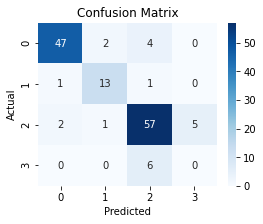

In [35]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(x_train, y_train)

# Predict on test set
y_pred = RF_model.predict(x_test)

# Evaluate performance
print("Random Forest Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

MLP Classifier
--------------------------
Accuracy: 0.8057553956834532
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.85      0.89        53
           2       0.87      0.87      0.87        15
           3       0.79      0.83      0.81        65
           4       0.00      0.00      0.00         6

    accuracy                           0.81       139
   macro avg       0.65      0.64      0.64       139
weighted avg       0.82      0.81      0.81       139



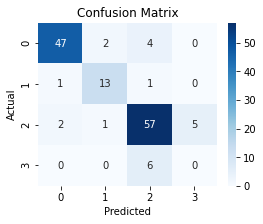

In [36]:
from sklearn.neural_network import MLPClassifier

MLP_model = MLPClassifier(
    hidden_layer_sizes=(256, 64, 32),
    activation='identity',
    solver='lbfgs',
    early_stopping=True,
    max_iter=2000,
    random_state=19
)

MLP_model.fit(x_train, y_train)

# Predict on test set
y_pred = MLP_model.predict(x_test)

# Evaluate performance
print("MLP Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model),('rf', RF_model),('mlp', MLP_model)],
    voting='soft'
)

voting_clf.fit(x_train, y_train)

# Predict on test set
y_pred = voting_clf.predict(x_test)

# Evaluate performance
print("Voting Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()